# 2: Example of Sentinel-1 RTC time series analysis


Now that we have done so much work to organize these two datasets and prepare them for analysis, let's explore the data with a scientific question in mind.

In this example, we have data over a specific area of interest covering two glaciers and two proglacial lakes in the Central Himalaya near the India-Chinese border. As a glaciologist, I might be interested in questions related to the conditions of these surface -- is there a seasonal pattern to proglacial lake conditions? Do they freeze during the winter, and if so, at similar times? What is the surface of the glacier like at certain times of year? SAR backscatter imagery may not conclusively answer any of these questions in itself, but it can provide important insights about surface conditions and how they change over time that could be used to answer some of these questions.

This notebook will walk through some initial steps of how you could use the data objects we've created to explore backscatter dynamics over time and space for the area of interest we have identified. 

## Learning objectives 

### Concepts
- Subset larger dataset to spatial areas of interest
- Computations and reductions
- Data visualization
  
### Techniques
- [GeoPandas](https://geopandas.org/en/stable/):  
      - Handling projections  
      - Spatial joins of multiple vector datasets   
      - Interactive data visualization  
- [Xarray](https://xarray.dev/) and [RioXarray](https://corteva.github.io/rioxarray/stable/):  
      - Clip raster object by a vector object  
      - Computations and reductions along different dimensions  
      - Data visualization

### Other useful resources
These are resources that contain additional examples and discussion of the content in this notebook and more.
- [Xarray user guide](https://docs.xarray.dev/en/stable/user-guide/index.html)
- [How do I...](https://docs.xarray.dev/en/stable/howdoi.html) this is **very** helpful!
- [Xarray High-level computational patterns](https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html) discussion of concepts and associated code examples
- [Parallel computing with dask](https://tutorial.xarray.dev/intermediate/xarray_and_dask.html) Xarray tutorial demonstrating wrapping of dask arrays

## Software and setup

In [1]:
%xmode minimal
import geopandas as gpd
import xarray as xr
from shapely import geometry
import matplotlib.pyplot as plt
import numpy as np

Exception reporting mode: Minimal


### Utility functions

In [2]:
def get_bbox_single(input_xr, buffer=0):
    """Takes input xr object (from itslive data cube), plots a quick map of the footprint.
    currently only working for granules in crs epsg 32645"""

    xmin = input_xr.coords["x"].data.min()
    xmax = input_xr.coords["x"].data.max()

    ymin = input_xr.coords["y"].data.min()
    ymax = input_xr.coords["y"].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]

    crs = input_xr.rio.crs

    polygon_geom = geometry.Polygon(pts_ls)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
    polygon_prj = polygon
    polygon = polygon_prj.to_crs(crs)

    # add a buffer if needed
    bounds = polygon.total_bounds
    # bounds = [bounds[0]-500, bounds[2]+500, bounds[1]-500, bounds[3]+500]

    bounds_xmin = bounds[0] - buffer
    bounds_xmax = bounds[2] + buffer
    bounds_ymin = bounds[1] - buffer
    bounds_ymax = bounds[3] + buffer

    bounds_ls = [
        (bounds_xmin, bounds_ymin),
        (bounds_xmax, bounds_ymin),
        (bounds_xmax, bounds_ymax),
        (bounds_xmin, bounds_ymax),
        (bounds_xmin, bounds_ymin),
    ]

    bounds_geom = geometry.Polygon(bounds_ls)
    bound_gdf = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[bounds_geom])
    bounds_prj = bound_gdf.to_crs(crs)

    return bounds_prj

In [3]:
def power_to_db(input_arr):
    return 10 * np.log10(np.abs(input_arr))

### Read in prepared RTC data

- this example will use ASF dataset

In [4]:
asf_cube = xr.open_dataset("../data/tutorial2/s1_asf_cube_updated.zarr")

/home/emmamarshall/miniforge3/envs/TEST_geospatial_datacube_book_env/lib/python3.11/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'netcdf4' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/home/emmamarshall/miniforge3/envs/TEST_geospatial_datacube_book_env/lib/python3.11/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'scipy' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)


In [5]:
asf_cube

<xarray.Dataset> Size: 265MB
Dimensions:                           (acq_date: 96, y: 396, x: 290)
Coordinates: (12/22)
  * acq_date                          (acq_date) datetime64[ns] 768B 2021-05-...
    area_or_clipped                   (acq_date) <U1 384B ...
    beam_mode                         (acq_date) <U2 768B ...
    data_take_id                      (acq_date) <U6 2kB ...
    deadreckoning_or_demmatch         (acq_date) <U1 384B ...
    granule_id                        (acq_date) <U67 26kB ...
    ...                                ...
    sensor                            (acq_date) <U3 1kB ...
    spatial_ref                       int64 8B ...
    terrain_correction_pixel_spacing  (acq_date) <U5 2kB ...
    unmasked_or_watermasked           (acq_date) <U1 384B ...
  * x                                 (x) float64 2kB 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3kB 3.102e+06 ... 3.09e+06
Data variables:
    ls                                (acq_date, y, x) float64 88MB ...
    vh                                (acq_date, y, x) float64 88MB ...
    vv                                (acq_date, y, x) float64 88MB ...

In [6]:
asf_cube = asf_cube.where(asf_cube.vv != 0.0, np.nan, drop=False)

### Read in vector data 

- Manually-drawn outlines of proglacial lakes

In [7]:
lakes = gpd.read_file(
    "https://github.com/e-marshall/sentinel1_rtc/raw/main/proglacial_lake_outline.geojson"
)
lakes_prj = lakes.to_crs("EPSG:32645")
lakes_prj

,id,geometry
0,1,"POLYGON ((623555.903 3099600.816, 623594.809 3..."
1,2,"POLYGON ((622405.254 3097521.050, 622268.598 3..."


Glacier outlines from Randolph Glacier Inventory

In [8]:
da_bbox = get_bbox_single(asf_cube)

In [9]:
rgi = gpd.read_parquet("../data/tutorial1/rgi7_region15_south_asia_east.parquet")
rgi.head(3)
rgi_prj = rgi.to_crs("epsg:32645")

rgi_sub = gpd.sjoin(rgi_prj, da_bbox, how="inner")

In [10]:
rgi_sub.explore()

In [11]:
rgi_sub

,rgi_id,o1region,o2region,glims_id,anlys_id,subm_id,src_date,cenlon,cenlat,utm_zone,...,zmax_m,zmed_m,zmean_m,slope_deg,aspect_deg,aspect_sec,dem_source,lmax_m,geometry,index_right
7637,RGI2000-v7.0-G-15-07638,15,15-02,G088225E27974N,910110,752,1994-07-11T00:00:00,88.220365,27.972294,45,...,5994.4390,5806.6396,5755.4230,15.617088,25.832253,2,COPDEM30,2594,"POLYGON Z ((620777.817 3094896.620 0.000, 6207...",0
7638,RGI2000-v7.0-G-15-07639,15,15-02,G088238E27974N,910161,752,1994-07-11T00:00:00,88.237935,27.973788,45,...,6465.8220,6339.7734,6309.8790,40.031345,298.723522,8,COPDEM30,498,"POLYGON Z ((621854.192 3094797.909 0.000, 6218...",0
7639,RGI2000-v7.0-G-15-07640,15,15-02,G088234E27981N,910162,752,1994-07-11T00:00:00,88.238417,27.981515,45,...,6421.7270,5994.4556,6006.6920,29.611990,348.181490,1,COPDEM30,1879,"POLYGON Z ((621854.192 3094797.909 0.000, 6218...",0
7640,RGI2000-v7.0-G-15-07641,15,15-02,G088262E27977N,910226,752,1994-07-11T00:00:00,88.261738,27.977135,45,...,6260.1143,6026.8193,6013.2144,34.200127,310.604237,8,COPDEM30,866,"POLYGON Z ((624319.339 3095066.823 0.000, 6243...",0
7641,RGI2000-v7.0-G-15-07642,15,15-02,G088259E27982N,910225,752,1994-07-11T00:00:00,88.261055,27.972390,45,...,6502.5230,5980.4424,5948.8110,18.338373,327.105179,8,COPDEM30,6003,"POLYGON Z ((623317.607 3091695.566 0.000, 6232...",0
7642,RGI2000-v7.0-G-15-07643,15,15-02,G088279E27984N,910257,752,1994-07-11T00:00:00,88.271817,27.980736,45,...,6537.9653,5903.1064,5881.2450,16.811453,326.488998,8,COPDEM30,6103,"POLYGON Z ((626126.789 3095356.801 0.000, 6261...",0
7643,RGI2000-v7.0-G-15-07644,15,15-02,G088284E27976N,910296,752,1994-07-11T00:00:00,88.284104,27.976187,45,...,6133.6323,6029.2090,6019.8050,45.767376,40.372757,2,COPDEM30,258,"POLYGON Z ((626126.789 3095356.801 0.000, 6261...",0
7644,RGI2000-v7.0-G-15-07645,15,15-02,G088288E27988N,910307,752,1994-07-11T00:00:00,88.288492,27.988205,45,...,6526.9630,5740.4824,5796.3916,14.749528,348.660873,1,COPDEM30,5450,"POLYGON Z ((627942.940 3094638.505 0.000, 6279...",0
7645,RGI2000-v7.0-G-15-07646,15,15-02,G088299E27985N,910334,752,1994-07-11T00:00:00,88.298585,27.985165,45,...,5769.7510,5688.6494,5682.5800,17.846190,59.825836,2,COPDEM30,832,"POLYGON Z ((627829.682 3095916.635 0.000, 6278...",0
7646,RGI2000-v7.0-G-15-07647,15,15-02,G088308E27979N,910375,752,1994-07-11T00:00:00,88.312007,27.980761,45,...,6400.4873,5625.8810,5621.9165,18.837168,28.814968,2,COPDEM30,3531,"POLYGON Z ((628078.739 3094643.719 0.000, 6280...",0


In [12]:
rgi_2 = rgi_sub.loc[rgi_sub["glims_id"].isin(["G088279E27984N", "G088259E27982N"])]

In [13]:
rgi_2

,rgi_id,o1region,o2region,glims_id,anlys_id,subm_id,src_date,cenlon,cenlat,utm_zone,...,zmax_m,zmed_m,zmean_m,slope_deg,aspect_deg,aspect_sec,dem_source,lmax_m,geometry,index_right
7641,RGI2000-v7.0-G-15-07642,15,15-02,G088259E27982N,910225,752,1994-07-11T00:00:00,88.261055,27.972390,45,...,6502.5230,5980.4424,5948.811,18.338373,327.105179,8,COPDEM30,6003,"POLYGON Z ((623317.607 3091695.566 0.000, 6232...",0
7642,RGI2000-v7.0-G-15-07643,15,15-02,G088279E27984N,910257,752,1994-07-11T00:00:00,88.271817,27.980736,45,...,6537.9653,5903.1064,5881.245,16.811453,326.488998,8,COPDEM30,6103,"POLYGON Z ((626126.789 3095356.801 0.000, 6261...",0


## TODO
handdrew the lake outllines off of rgi6, looks like rgi7 slightly longer, should update lake outlines


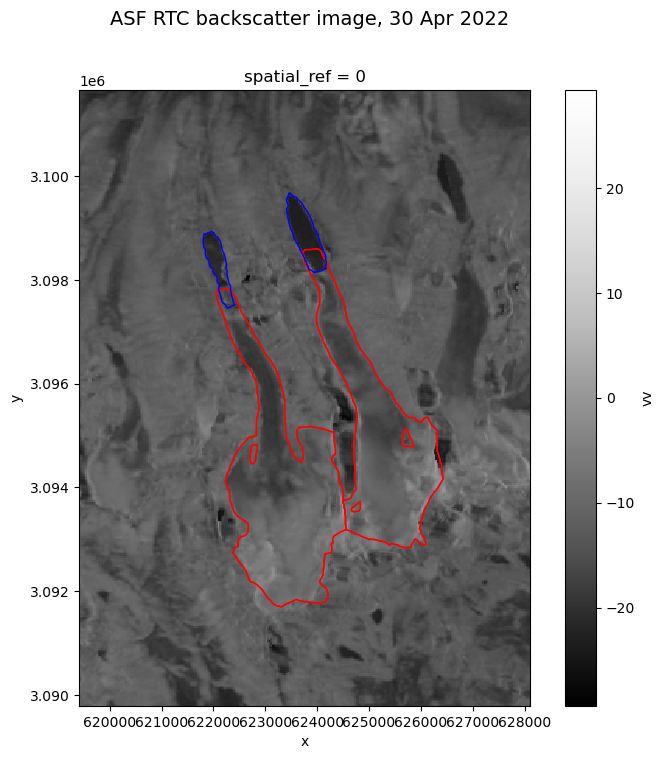

In [14]:
fig, ax = plt.subplots(figsize=(9, 8))

power_to_db(asf_cube.vv.mean(dim=["acq_date"])).plot(ax=ax, cmap=plt.cm.Greys_r)

rgi_2.plot(edgecolor="r", facecolor="none", ax=ax)
rgi_2.plot(edgecolor="r", facecolor="none", ax=ax)

lakes_prj.plot(ax=ax, facecolor="none", edgecolor="blue")

fig.suptitle("ASF RTC backscatter image, 30 Apr 2022", fontsize=14);

## Clip to lake extent

In [15]:
lake1 = lakes_prj.loc[lakes_prj["id"] == 1]
lake2 = lakes_prj.loc[lakes_prj["id"] == 2]

In [16]:
lake1_asf = asf_cube.rio.clip(lake1.geometry, lake1.crs)
lake2_asf = asf_cube.rio.clip(lake2.geometry, lake2.crs)

In [17]:
lake1_asf

<xarray.Dataset> Size: 3MB
Dimensions:                           (acq_date: 96, x: 26, y: 51)
Coordinates: (12/22)
  * acq_date                          (acq_date) datetime64[ns] 768B 2021-05-...
    area_or_clipped                   (acq_date) <U1 384B 'e' 'e' ... 'e' 'e'
    beam_mode                         (acq_date) <U2 768B 'IW' 'IW' ... 'IW'
    data_take_id                      (acq_date) <U6 2kB '047321' ... '052C00'
    deadreckoning_or_demmatch         (acq_date) <U1 384B 'd' 'd' ... 'd' 'd'
    granule_id                        (acq_date) <U67 26kB 'S1A_IW_SLC__1SDV_...
    ...                                ...
    sensor                            (acq_date) <U3 1kB 'S1A' 'S1A' ... 'S1A'
    terrain_correction_pixel_spacing  (acq_date) <U5 2kB 'RTC30' ... 'RTC30'
    unmasked_or_watermasked           (acq_date) <U1 384B 'u' 'u' ... 'u' 'u'
  * x                                 (x) float64 208B 6.234e+05 ... 6.242e+05
  * y                                 (y) float64 408B 3.1e+06 ... 3.098e+06
    spatial_ref                       int64 8B 0
Data variables:
    ls                                (acq_date, y, x) float64 1MB nan ... nan
    vh                                (acq_date, y, x) float64 1MB nan ... nan
    vv                                (acq_date, y, x) float64 1MB nan ... nan

In [18]:
lakes_prj["color"] = ["r", "b"]
lakes_prj

,id,geometry,color
0,1,"POLYGON ((623555.903 3099600.816, 623594.809 3...",r
1,2,"POLYGON ((622405.254 3097521.050, 622268.598 3...",b


## Data visualization

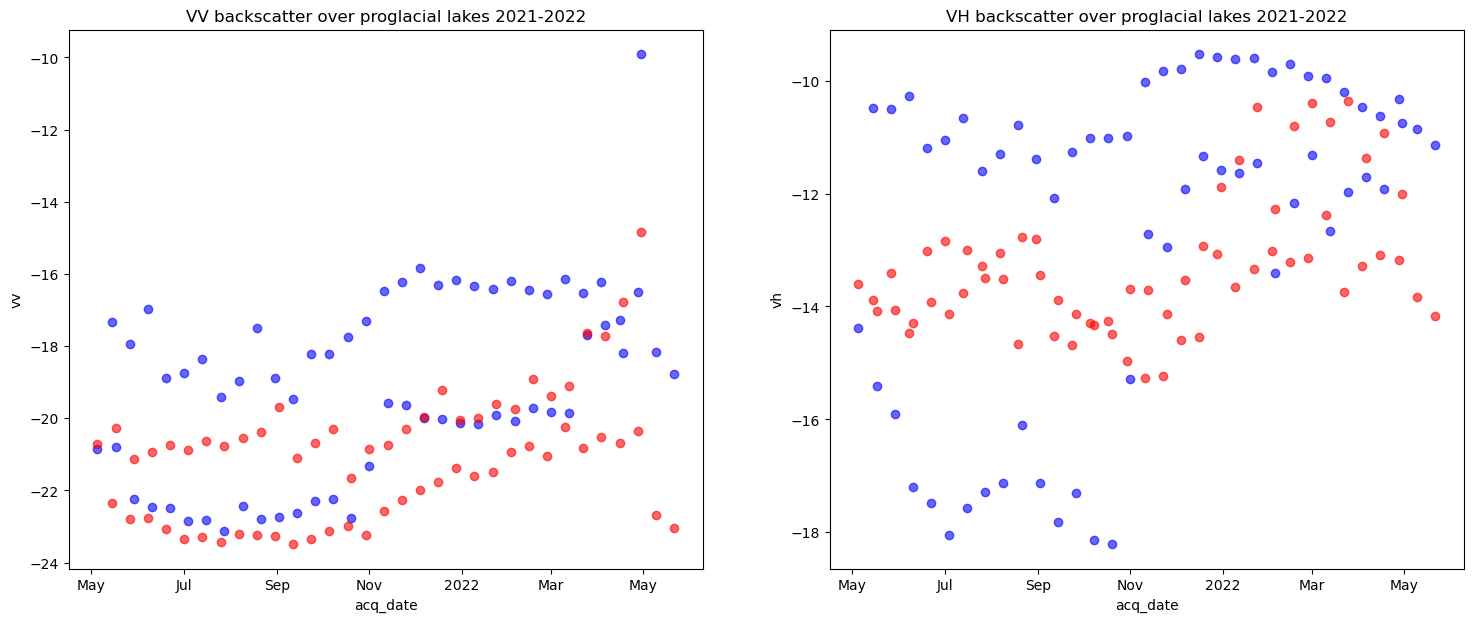

In [19]:
from matplotlib.lines import Line2D

fig, axs = plt.subplots(ncols=2, figsize=(18, 7))

# scatter plot VV
power_to_db(lake2_asf.vv.mean(dim=["x", "y"])).plot(
    ax=axs[0], color="blue", marker="o", linewidth=0, alpha=0.6
)
power_to_db(lake1_asf.vv.mean(dim=["x", "y"])).plot(
    ax=axs[0], color="red", marker="o", linewidth=0, alpha=0.6
)
# scatter plot VH
power_to_db(lake2_asf.vh.mean(dim=["x", "y"])).plot(
    ax=axs[1], color="blue", marker="o", linewidth=0, alpha=0.6
)
power_to_db(lake1_asf.vh.mean(dim=["x", "y"])).plot(
    ax=axs[1], color="red", marker="o", linewidth=0, alpha=0.6
)
axs[0].set_title("VV backscatter over proglacial lakes 2021-2022")
axs[1].set_title("VH backscatter over proglacial lakes 2021-2022")

legend_elements = [
    Line2D([0], [0], color="r", lw=3, label="lake 1"),
    Line2D([0], [0], color="b", lw=3, label="lake 2"),
];

What observations can we make about VV and VH variability in the above plots? What would we want to look at next to further explore those observations? 